# 1. Handling imports

In [2]:
import sys
import os

# Add 'predrnn' to sys.path so imports like 'from core...' work
project_root = os.path.abspath("predrnn")  # or use full path if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)



# PyTorch (related) imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else "cpu")
device = 'cpu'
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import clear_output

# Custom imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel, architectures

# predrnn imports
from predrnn.core.models.predrnn_v2 import RNN as PredRNN
from predrnn.configparser import build_predrnn_args
from predrnn.core.data_provider import datasets_factory

# for reproducibility
np.random.seed(42)


Torch device: cpu


# 2. handling file paths

In [3]:
autoencoder_root_path = Path("autoencoder") / "models"
predrnn_root_path = Path("predrnn") / "checkpoints"
predrnn_base_data_dir = Path("dataset")

# 3. Loading the trained models
## A. Autoencoders

In [4]:
def load_autoencoder(latent_dimension: int) -> AutoencoderModel:
    """Fetches the trained autoencoder with given latent dimension.

    Args:
        latent_dimension (int): The latent dimension the encoder reduces the inputs into
        
    Returns:
        AutoencoderModel: The loaded autoencoder

    """
    architecture_mapping = {
        64: 1,
        32: 2,
        16: 3
    }
    architecture = architectures[architecture_mapping[latent_dimension]]
    
    best_trial = {
        64: "model_trial_2_1.pt",
        32: "model_trial_1_2.pt",
        16: "model_trial_0_3.pt"
    }
    
    autoencoder =  AutoencoderModel(epochs=200, encoder=architecture["encoder"], decoder=architecture["decoder"]).to(device)
    autoencoder.load(autoencoder_root_path / best_trial[latent_dimension], device=device)
    autoencoder.eval()
    
    return autoencoder

autencoder_64 = load_autoencoder(64) # 64x64 autencoder
autencoder_32 = load_autoencoder(32) # 32x32 autencoder
autencoder_16 = load_autoencoder(16) # 16x16 autencoder


## B. PredRNN

In [5]:
from predrnn.core.models.model_factory import Model as PredRNNModel

def load_predRNN(latent_dimension: int = None) -> PredRNN:
    """Loads a trained PredRNN network.

    Args:
        latent_dimension (int, optional): When given, the network that takes in the provided latent_dimension will be loaded. 
        Defaults to None which results in the vanilla network without autoencoder preprocessing.

    Returns:
        PredRNN: The loaded network.
        
    """
    # Load vanilla model if no latent dimension is given
    if latent_dimension is None:
        # Hard coded Vanilla configs

        # trained_model = torch.load(predrnn_root_path / "kth_predrnn_vanilla" / "model.ckpt-400", map_location=device)
        configs = build_predrnn_args(img_width=128, 
                                    data_dir=str((predrnn_base_data_dir / 'kth').resolve()), 
                                    result_checkpoint_dir='kth_predrnn_vanilla')
        predRNN = PredRNNModel(configs)
        predRNN.load(str((predrnn_root_path / "kth_predrnn_vanilla" / "model.ckpt-400").resolve()))
        # num_hidden = [int(x) for x in config.num_hidden.split(',')]
        # num_layers = len(num_hidden)
        # predRNN = Model.load()
        
        # PredRNN(num_layers, num_hidden, config)
        # predRNN.load_state_dict(trained_model['net_param'])
        
    else:
        # Dynamic loading of latent model based on latent dimension
        # trained_model = torch.load(predrnn_root_path / f"kth_predrnn_{latent_dimension}" / "model.ckpt-400", map_location=device)
        configs = build_predrnn_args(img_width=latent_dimension, 
                                    data_dir=str((predrnn_base_data_dir / 'encoded' / str(latent_dimension)).resolve()), 
                                    result_checkpoint_dir=f'kth_predrnn_{latent_dimension}')
        
        predRNN = PredRNNModel(configs)
        
        # num_hidden = [int(x) for x in config.num_hidden.split(',')]
        # num_layers = len(num_hidden)
        # predRNN = PredRNN(num_layers, num_hidden, config)
        # predRNN.load_state_dict(trained_model['net_param'])
        
    return predRNN

predrnn_native = load_predRNN() # 128x128 (native) predRNN model
predrnn_64 = load_predRNN(64)   # 64x64 PredRNN
predrnn_32 = load_predRNN(32)   # 32x32 PredRNN
predrnn_16 = load_predRNN(16)   # 16x16 PredRNN


load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_vanilla/model.ckpt-400


## 4. Load test dataset

In [6]:
def load_test_dataset(latent_dimension: int, data_dir: Path):
    if latent_dimension is None:
        dataset_name = 'action'
        data_path = str((data_dir / 'kth').resolve())
        img_width = 128
    else:
        dataset_name = 'latent'
        data_path = str((data_dir / 'encoded' / str(latent_dimension)).resolve())
        img_width = latent_dimension
        
    test_input_handle = datasets_factory.data_provider(
            dataset_name=dataset_name, 
            train_data_paths=data_path, 
            valid_data_paths=data_path, 
            batch_size=4, 
            img_width=img_width,
            seq_length=20, 
            injection_action='concat', 
            is_training=False)
    return test_input_handle

test = load_test_dataset(16, predrnn_base_data_dir)

begin load data/Users/maxneerken/Documents/aml/predrnn-pytorch-AML/dataset/encoded/16
Preparing to load 13094 video frames.
there are 13094 pictures
there are 4147 sequences


## 5. Perform forward pass

In [60]:
# autoencoder = load_autoencoder(16)
predrnn = load_predRNN()
test_handle = load_test_dataset(latent_dimension=None, data_dir=predrnn_base_data_dir)

load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_vanilla/model.ckpt-400
begin load data/Users/maxneerken/Documents/aml/predrnn-pytorch-AML/dataset/kth
Preparing to load 13094 video frames.
there are 13094 pictures
there are 4147 sequences


In [63]:
# Training Params #
img_width = 128
img_channel = 1
patch_size = 4
batch_size = 4
total_length = 20
input_length = 10
# # # # # # # # # #

In [64]:
import datetime

from predrnn.core.utils import preprocess

# Reverse schedule sampling #
mask_input = 1

real_input_flag = np.zeros(
    (batch_size,
        total_length - mask_input - 1,
        img_width // patch_size,
        img_width // patch_size,
        patch_size ** 2 * img_channel))

real_input_flag[:, :input_length - 1, :, :] = 1.0
# # # # # # # # # # # # # # #

batch_id = 1
test_ims = test_handle.get_batch()

test_dat = preprocess.reshape_patch(test_ims, patch_size)
test_ims = test_ims[:, :, :, :, :img_channel]

img_gen = predrnn.test(test_dat, real_input_flag)

img_gen = preprocess.reshape_patch_back(img_gen, patch_size)

output_length = total_length - input_length 
img_out = img_gen[:, -output_length:]

In [53]:
img_gen.shape

(4, 19, 16, 16, 1)

In [66]:
batch_1 = img_gen[0]
output_tensor = torch.from_numpy(batch_1)
reshaped_tensor = output_tensor.reshape(19, 1, 128, 128)
# decoded = autoencoder.decode(reshaped_tensor)

numpyy = reshaped_tensor.detach().numpy()

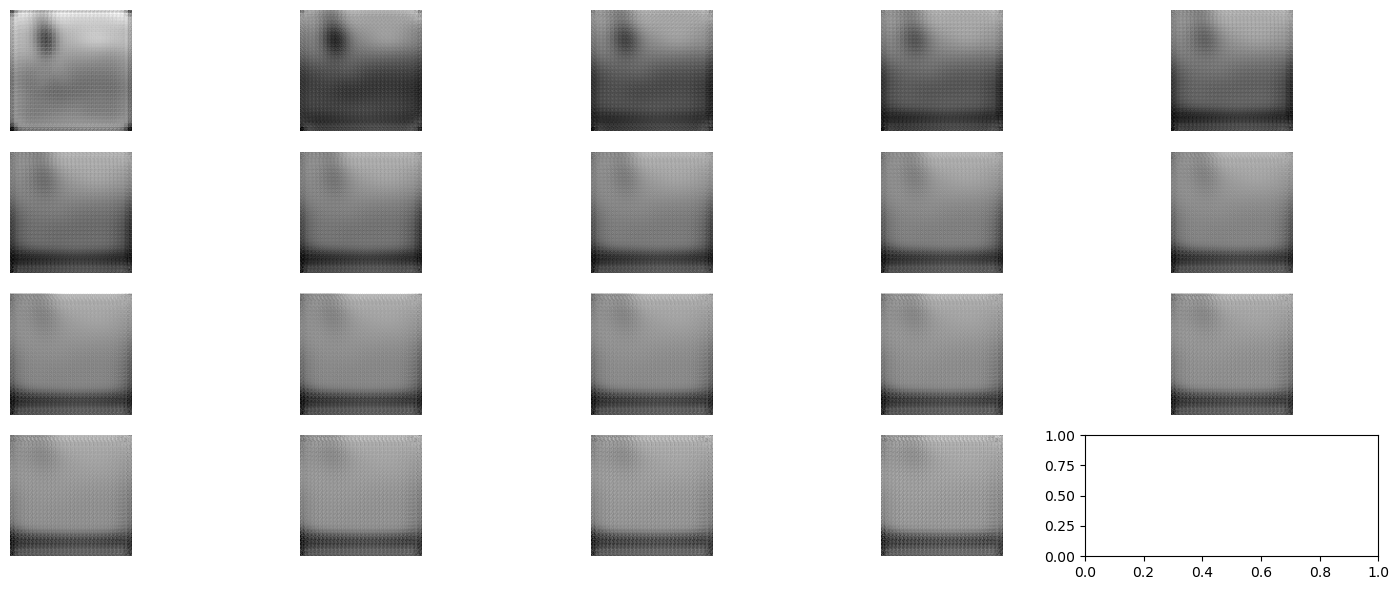

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming decoded_np is your numpy array with shape (10, 1, 128, 128)
# For demonstration, let's create a random array

# Set up the figure and axes
fig, axes = plt.subplots(4, 5, figsize=(15, 6))  # 2 rows, 5 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image and plot it
for i in range(19):
    # Squeeze the image to remove the channel dimension
    img = numpyy[i].squeeze()  # Shape will be (128, 128)
    axes[i].imshow(img, cmap='gray')  # Display the image in grayscale
    axes[i].axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()


In [34]:
import cv2

# Assuming img_out is your array of images
for image in decoded_np:  # Iterate over the first 10 images
    cv2.imshow(f'Image', image)  # Reshape if necessary
    cv2.waitKey(0)  # Wait for a key press to close the window

cv2.destroyAllWindows()  # Close all OpenCV windows


error: OpenCV(4.11.0) /Users/runner/miniforge3/conda-bld/libopencv_1739279513328/work/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<0, 2, 5>>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 128


In [12]:



print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'test...')
test_handle.begin(do_shuffle=False)

avg_mse = 0
batch_id = 0
img_mse, ssim, psnr = [], [], []
lp = []

for i in range(total_length - input_length):
    img_mse.append(0)
    ssim.append(0)
    psnr.append(0)
    lp.append(0)

# Reverse schedule sampling #
mask_input = 1

real_input_flag = np.zeros(
    (batch_size,
        total_length - mask_input - 1,
        img_width // patch_size,
        img_width // patch_size,
        patch_size ** 2 * img_channel))

real_input_flag[:, :input_length - 1, :, :] = 1.0
# # # # # # # # # # # # # # #

while (test_handle.no_batch_left() == False):
    batch_id = batch_id + 1
    test_ims = test_handle.get_batch()
    test_dat = preprocess.reshape_patch(test_ims, patch_size)
    test_ims = test_ims[:, :, :, :, :img_channel]
    img_gen = model.test(test_dat, real_input_flag)

    img_gen = preprocess.reshape_patch_back(img_gen, patch_size)
    output_length = total_length - input_length 
    img_out = img_gen[:, -output_length:]

    # MSE per frame
    for i in range(output_length):
        x = test_ims[:, i + input_length, :, :, :]
        gx = img_out[:, i, :, :, :]
        gx = np.maximum(gx, 0)
        gx = np.minimum(gx, 1)
        mse = np.square(x - gx).sum()
        img_mse[i] += mse
        avg_mse += mse
        
        # cal lpips
        img_x = np.zeros([batch_size, 3, img_width, img_width])
        img_x[:, 0, :, :] = x[:, :, :, 0]
        img_x[:, 1, :, :] = x[:, :, :, 0]
        img_x[:, 2, :, :] = x[:, :, :, 0]
        img_x = torch.FloatTensor(img_x)
        
        img_gx = np.zeros([batch_size, 3, img_width, img_width])
        img_gx[:, 0, :, :] = gx[:, :, :, 0]
        img_gx[:, 1, :, :] = gx[:, :, :, 0]
        img_gx[:, 2, :, :] = gx[:, :, :, 0]
        img_gx = torch.FloatTensor(img_gx)
        lp_loss = loss_fn_alex(img_x, img_gx)
        lp[i] += torch.mean(lp_loss).item()

        real_frm = np.uint8(x * 255)
        pred_frm = np.uint8(gx * 255)

        psnr[i] += metrics.batch_psnr(pred_frm, real_frm)
        for b in range(batch_size):
            score, _ = compare_ssim(pred_frm[b], real_frm[b], full=True, channel_axis=2)
            ssim[i] += score

    test_handle.next()

avg_mse = avg_mse / (batch_id * batch_size)
print('mse per seq: ' + str(avg_mse))
for i in range(total_length - input_length):
    print(img_mse[i] / (batch_id * batch_size))

ssim = np.asarray(ssim, dtype=np.float32) / (batch_size * batch_id)
print('ssim per frame: ' + str(np.mean(ssim)))
for i in range(total_length - input_length):
    print(ssim[i])

psnr = np.asarray(psnr, dtype=np.float32) / batch_id
print('psnr per frame: ' + str(np.mean(psnr)))
for i in range(total_length - input_length):
    print(psnr[i])

lp = np.asarray(lp, dtype=np.float32) / batch_id
print('lpips per frame: ' + str(np.mean(lp)))
for i in range(total_length - input_length):
    print(lp[i])

2025-06-30 13:04:15 test...


NameError: name 'model' is not defined

## 6. Do Tests